In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [87]:
# Define column names (since the dataset doesn't include headers)
column_names = ["Feature 0", "Feature 1", "Feature 2", "Feature 3", "Species"]

url = "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"
df = pd.read_csv(url, names=column_names)

# Display the first few rows
#print(df.head(50))

In [88]:
species_list = ["Setosa", "Versicolor", "Virginica"]
features_list = ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']
train_list, test_list = [], []

for species in species_list:
    species_data = df[df["Species"] == species]
    X_species = species_data[['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']].values
    y_species = species_data['Species'].values  # If you need labels
    
    # 80-20 split for each species
    X_train, X_test, y_train, y_test = train_test_split(
        X_species, y_species, test_size=0.6, random_state=42, stratify=y_species
    )

    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))

# Combine the train and test data
X_train = np.vstack([t[0] for t in train_list])
y_train = np.hstack([t[1] for t in train_list])

X_test = np.vstack([t[0] for t in test_list])
y_test = np.hstack([t[1] for t in test_list])

# print(X_test)
# print(y_test)

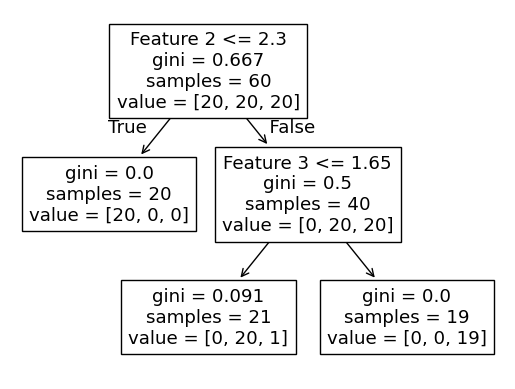

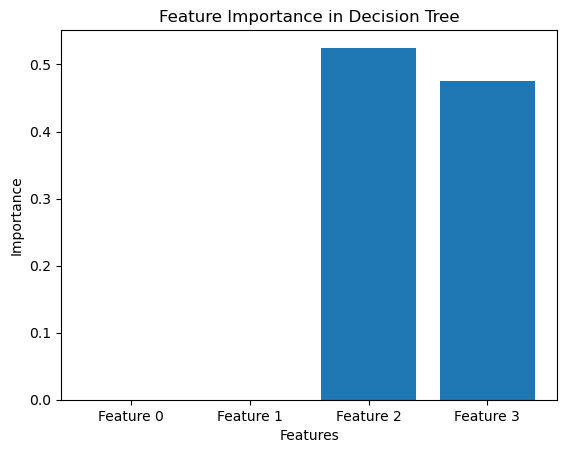

In [89]:
weak_learner = DecisionTreeClassifier(max_leaf_nodes=3)
dtree = weak_learner.fit(X_train, y_train)

#Plot tree
tree.plot_tree(dtree, feature_names=features_list)
plt.show()

#checking why Feature 0 and Feature 1 are not used
feature_importance = dtree.feature_importances_ 
plt.bar(features_list, feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Decision Tree")
plt.show()

In [90]:
n_estimators = 200
adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    algorithm ='SAMME',
    n_estimators=n_estimators,
    random_state=42,
).fit(X_train, y_train)

In [91]:
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, dtree.predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.056


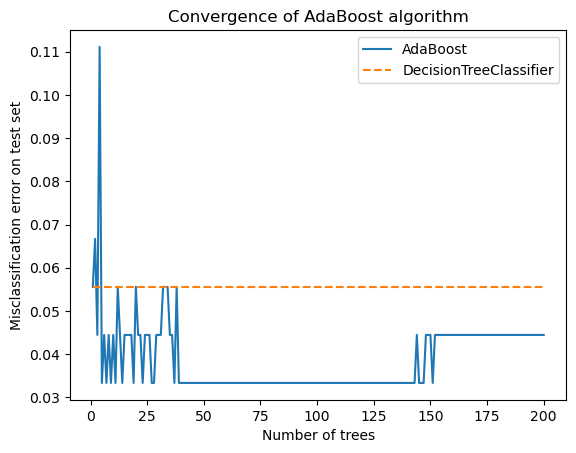

In [92]:
# staged_predictions = list(adaboost_clf.staged_predict(X_test))  # Convert to list
# n_trees_actual = len(staged_predictions)

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators+1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)

plt.legend(["AdaBoost", "DecisionTreeClassifier"], loc=1)
plt.show()

AdaBoost actually used 200 trees, not 200


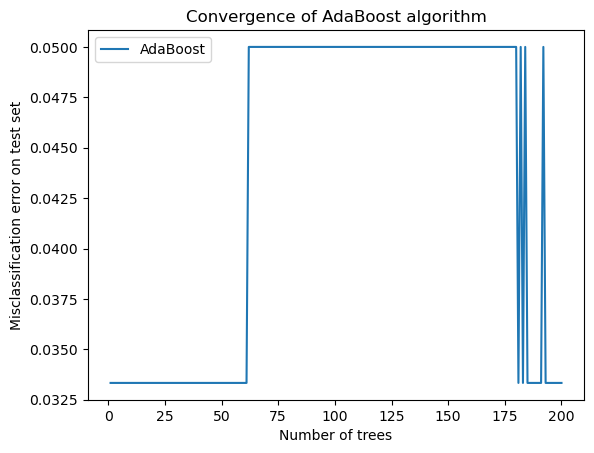

In [81]:
staged_predictions = list(adaboost_clf.staged_predict(X_test))  # Convert to list
n_trees_actual = len(staged_predictions)  # Get actual number of trees

print(f"AdaBoost actually used {n_trees_actual} trees, not {n_estimators}")

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_trees_actual + 1),  # Use actual count
        "AdaBoost": [misclassification_error(y_test, y_pred) for y_pred in staged_predictions],
    }
).set_index("Number of trees")

boosting_errors.plot()
plt.ylabel("Misclassification error on test set")
plt.title("Convergence of AdaBoost algorithm")
plt.show()
